In [1]:
# ✅ Instalación de requerimientos (Python 3.9.6)
!pip install google-play-scraper sentence-transformers matplotlib seaborn pandas feedparser transformers nltk wordcloud

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import re
import feedparser

from google_play_scraper import reviews, app, Sort
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline
from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

sns.set(style='whitegrid')

/Users/facundorodriguez/CascadeProjects/app_store_scraper/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/facundorodriguez/CascadeProjects/app_store_scraper/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/facundorodriguez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Función para obtener reviews desde Google Play Store
def get_playstore_reviews(app_id, lang='es', country='AR', days_back=90):
    result, _ = reviews(
        app_id,
        lang=lang,
        country=country,
        sort=Sort.NEWEST,  # Usamos el enum correcto
        count=2000
    )
    df = pd.DataFrame(result)
    df['date'] = pd.to_datetime(df['at'])
    df.rename(columns={'score': 'rating'}, inplace=True)
    cutoff = dt.datetime.now() - dt.timedelta(days=days_back)
    return df[df['date'] >= cutoff]

# Función para obtener reviews desde App Store vía RSS de iTunes
def get_itunes_reviews(app_store_id, days_back=90):
    # URL del RSS de reseñas de iTunes (formato JSON)
    url = f"https://itunes.apple.com/rss/customerreviews/id/{app_store_id}/json"
    feed = feedparser.parse(url)
    reviews_list = []
    # El primer entry suele ser metadata, por lo que se omite
    for entry in feed.entries[1:]:
        # Validar que la entrada tenga el campo de rating
        if 'im_rating' in entry:
            try:
                rating = int(entry['im_rating'])
            except:
                rating = None
        else:
            rating = None
        title = entry.get('title', '')
        # El contenido suele venir en 'content' o en 'summary'
        if 'content' in entry and len(entry.content) > 0:
            content = entry.content[0].value
        else:
            content = entry.get('summary', '')
        review_date = pd.to_datetime(entry.get('updated'))
        reviews_list.append({
            'date': review_date,
            'rating': rating,
            'title': title,
            'content': content
        })
    df = pd.DataFrame(reviews_list)
    if df.empty or "date" not in df.columns:
        return df
    cutoff = dt.datetime.now() - dt.timedelta(days=days_back)
    df = df[df['date'] >= cutoff]
    return df

In [4]:
# Definir un diccionario con los IDs de cada app
apps = {
    "belo": {
         "play_store_id": "com.belo.android",
         "app_store_id": "1575614708"
    },
    "astropay": {
         "play_store_id": "com.astropaycard.android",
         "app_store_id": "1128476912"
    }
}

# Lista para almacenar los DataFrames de reviews
all_reviews_list = []

# Iterar sobre cada app y obtener reviews de ambas tiendas
for app_name, ids in apps.items():
    # Reviews desde Google Play
    play_reviews = get_playstore_reviews(ids["play_store_id"])
    if not play_reviews.empty:
        play_reviews["app"] = app_name
        play_reviews["store"] = "Play Store"
        all_reviews_list.append(play_reviews)
    
    # Reviews desde App Store (iTunes RSS)
    itunes_reviews = get_itunes_reviews(ids["app_store_id"])
    if not itunes_reviews.empty:
        itunes_reviews["app"] = app_name
        itunes_reviews["store"] = "App Store"
        all_reviews_list.append(itunes_reviews)

# Concatenar todas las reviews en un único DataFrame
all_reviews = pd.concat(all_reviews_list, ignore_index=True)

/var/folders/n_/7wrlkc1n7v9fblmdmds80y5r0000gn/T/ipykernel_74138/3901809647.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_reviews = pd.concat(all_reviews_list, ignore_index=True)


In [5]:
# Análisis de sentimiento con Transformers (modelo BETO para español)
sentiment_pipeline = pipeline("sentiment-analysis", model="finiteautomata/beto-sentiment-analysis")

def analyze_sentiment(text):
    if not text or not isinstance(text, str):
        return None
    result = sentiment_pipeline(text)[0]
    return result['label']

all_reviews["sentiment"] = all_reviews["content"].apply(analyze_sentiment)

Device set to use mps:0


In [6]:
# Cargar modelo de embeddings y pipeline de sentimiento
model = SentenceTransformer("distiluse-base-multilingual-cased-v1")
sentiment_pipeline = pipeline("sentiment-analysis", model="finiteautomata/beto-sentiment-analysis")

# Frases clave representativas para cada categoría
keywords = {
    "bug": ["error", "problemas", "bug", "no abre", "no funciona", "no me deja", "no puedo", "no anda", "no carga"],
    "feature": ["sería bueno", "me gustaría que tenga", "necesito que agreguen", "falta", "sumen", "es mejor", 
        "prefiero", "me gustaría que tenga", "sería genial si agregaran", "quisiera que se incluya", "necesito que ofrezcan"]
}

# Pre-codificar las keywords
keyword_embeddings = {k: model.encode(v, convert_to_tensor=True) for k, v in keywords.items()}

def classify_keywords_with_sentiment(text, threshold=0.6, bug_strict_threshold=0.7, feature_strict_threshold=0.75):
    """
    Evalúa la similitud de la review con las frases clave de cada categoría y combina el análisis de sentimiento.
    
    - Para bugs: Si la similitud supera 'threshold', se clasifica como bug; 
      pero si el sentimiento es POS y la similitud es inferior a 'bug_strict_threshold', se descarta.
    
    - Para features: Se clasifica como feature si la similitud supera 'threshold';
      sin embargo, si el sentimiento es POS se exige una similitud mayor a 'feature_strict_threshold' 
      para evitar falsos positivos.
    """
    if not text or not isinstance(text, str):
        return pd.Series({"is_bug": False, "is_feature": False})
    
    # Obtener sentimiento (por ejemplo: "POS", "NEG", "NEU")
    sentiment_result = sentiment_pipeline(text)[0]
    sentiment_label = sentiment_result['label'].upper()
    
    # Calcular embedding del texto
    text_embedding = model.encode(text, convert_to_tensor=True)
    scores = {}
    for category, emb_list in keyword_embeddings.items():
        sim = util.cos_sim(text_embedding, emb_list)
        scores[category] = sim.max().item()
    
    # Clasificar bugs
    is_bug = scores["bug"] > threshold
    if sentiment_label == "POS" and scores["bug"] < bug_strict_threshold:
        is_bug = False
    
    # Clasificar feature requests
    is_feature = scores["feature"] > threshold
    if sentiment_label == "POS" and scores["feature"] < feature_strict_threshold:
        is_feature = False
    
    return pd.Series({
        "is_bug": is_bug,
        "is_feature": is_feature
    })

# Aplicar la función a las reviews (suponiendo que la columna del texto es "content")
tags = all_reviews["content"].apply(classify_keywords_with_sentiment)
all_reviews = pd.concat([all_reviews, tags], axis=1)

# Visualizamos algunos ejemplos
all_reviews[["content", "is_bug", "is_feature"]].head(10)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Device set to use mps:0


,content,is_bug,is_feature
0,te cobran todos los impuestos de argentina. es...,False,False
1,mi experiencia al usar belo fue excelente esto...,False,False
2,tengo una semana tratando de crear un perfil y...,False,False
3,muy buena y fácil,False,False
4,me cuesta tanto volver a entrar de nuevo y no,False,False
5,es muy practica y segura,False,False
6,no puedo ingresar,True,False
7,no me deja avanzar,True,False
8,alguna otra app similar para comprar en reales...,False,False
9,Nonexite la atencion al cliente yabque no resp...,False,False


In [8]:
def extract_topics(reviews, n_topics=5, n_top_words=10):
    """
    Extrae los temas más recurrentes de un listado de reviews utilizando LDA.
    
    Parámetros:
      reviews (list o pd.Series): Lista o serie de textos de reviews.
      n_topics (int): Número de temas a extraer.
      n_top_words (int): Número de palabras clave que se mostrarán por tema.
      
    Retorna:
      dict: Un diccionario donde las llaves son nombres de temas y los valores son listas con las palabras clave.
    """
    # Usar las stop words en español de NLTK
    spanish_stopwords = stopwords.words('spanish')
    
    # Vectorizar el texto usando CountVectorizer con la lista de stop words
    vectorizer = CountVectorizer(stop_words=spanish_stopwords)
    X = vectorizer.fit_transform(reviews)
    
    # Aplicar LDA para extraer temas
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X)
    
    feature_names = vectorizer.get_feature_names_out()
    topics = {}
    
    # Extraer las n_top_words de cada tema
    for topic_idx, topic in enumerate(lda.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topics[f"Tema {topic_idx+1}"] = top_features
        
    return topics

for sentiment in all_reviews['sentiment'].unique():
    subset = all_reviews[all_reviews['sentiment'] == sentiment]['content']
    print(f"\nTópicos para reviews con sentimiento {sentiment}:")
    topics = extract_topics(subset, n_topics=5, n_top_words=10)
    for topic, words in topics.items():
        print(f"{topic}: {', '.join(words)}")


Tópicos para reviews con sentimiento NEG:
Tema 1: cuenta, dinero, si, nunca, app, aplicación, plata, soporte, puedo, deja
Tema 2: app, deja, soporte, aplicación, pagar, ahora, datos, nunca, dinero, hacer
Tema 3: cuenta, dinero, app, puedo, pagar, dice, deja, error, respuesta, ingresar
Tema 4: dinero, cuenta, app, plata, aplicación, hace, días, nunca, identidad, veces
Tema 5: app, dinero, puedo, hace, plata, entrar, cuenta, aplicación, abrir, deja

Tópicos para reviews con sentimiento POS:
Tema 1: brasil, genial, bien, usar, fácil, excelente, aplicación, pix, pagar, app
Tema 2: buena, excelente, app, espectacular, útil, ahora, exelente, 10, mejor, experiencia
Tema 3: funciona, bien, perfecto, app, gracias, ahora, problema, verdad, ningún, comprar
Tema 4: aplicación, excelente, 10, brasil, buenísimo, mejor, momento, recomiendo, buenísima, super
Tema 5: bueno, mejor, rápida, billetera, práctico, fácil, cotización, buena, virtual, gusta

Tópicos para reviews con sentimiento NEU:
Tema 1: c

In [9]:
# Agregación semanal de las reviews
all_reviews['week'] = pd.to_datetime(all_reviews['date']).dt.to_period("W").apply(lambda r: r.start_time)

# Asegurarse de que las columnas 'sentiment', 'is_bug' e 'is_feature' existan
for col in ['sentiment', 'is_bug', 'is_feature']:
    if col not in all_reviews.columns:
         all_reviews[col] = None  

weekly_summary = all_reviews.groupby(['app', 'store', 'week']).agg(
    avg_rating=('rating', 'mean'),
    review_count=('rating', 'count'),
    positive_sentiment=('sentiment', lambda x: (x.str.contains("POS", case=False, na=False)).sum()),
    negative_sentiment=('sentiment', lambda x: (x.str.contains("NEG", case=False, na=False)).sum()),
    feature_requests=('is_feature', 'sum'),
    bug_reports=('is_bug', 'sum')
).reset_index()

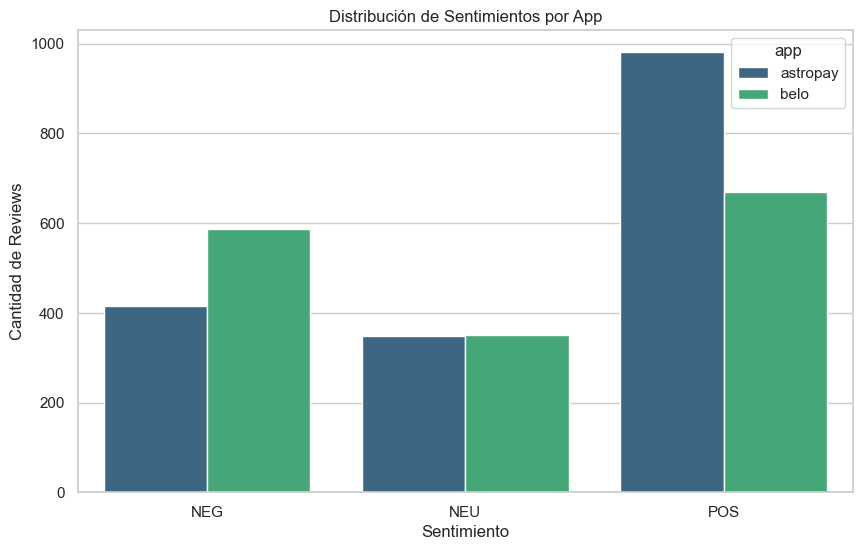

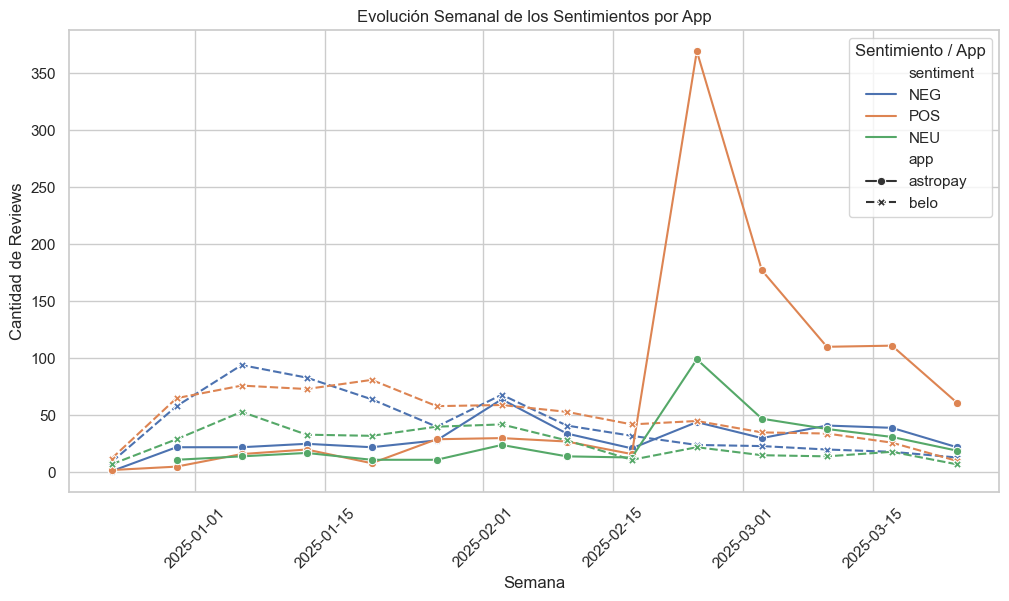

/var/folders/n_/7wrlkc1n7v9fblmdmds80y5r0000gn/T/ipykernel_74138/740903021.py:32: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(x="rating", y="sentiment_score", data=all_reviews, hue="app",


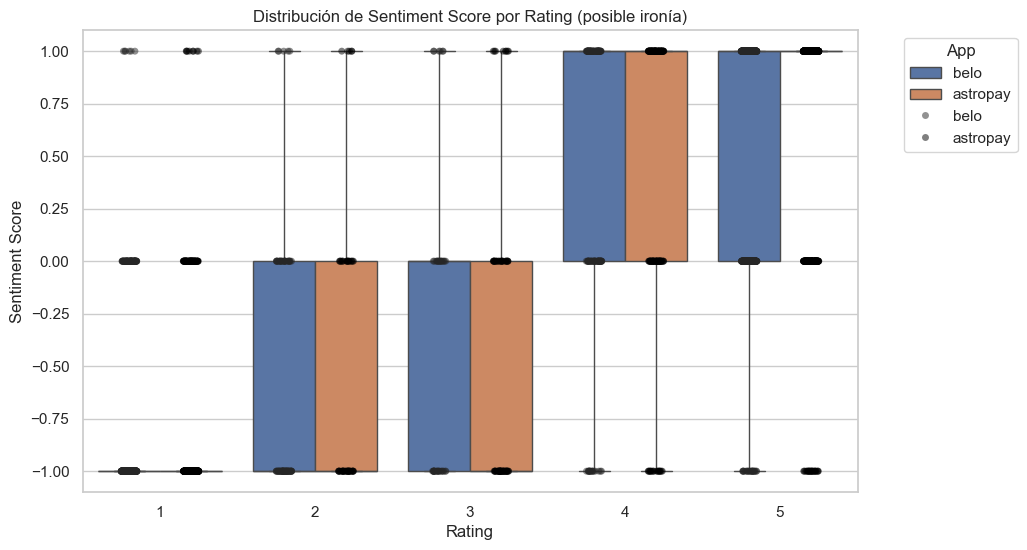

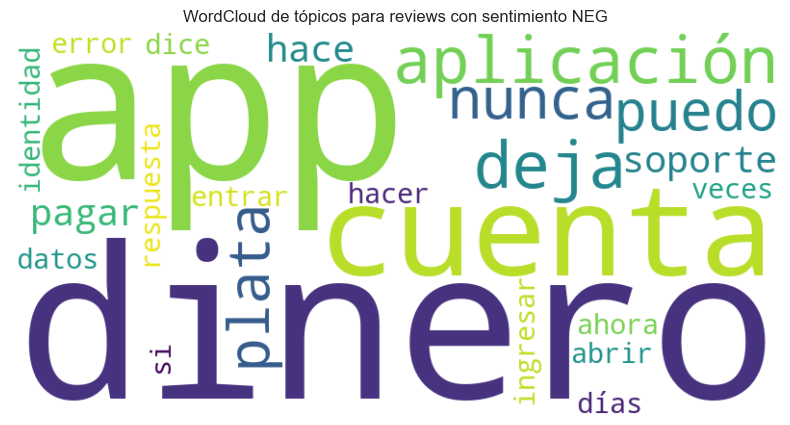

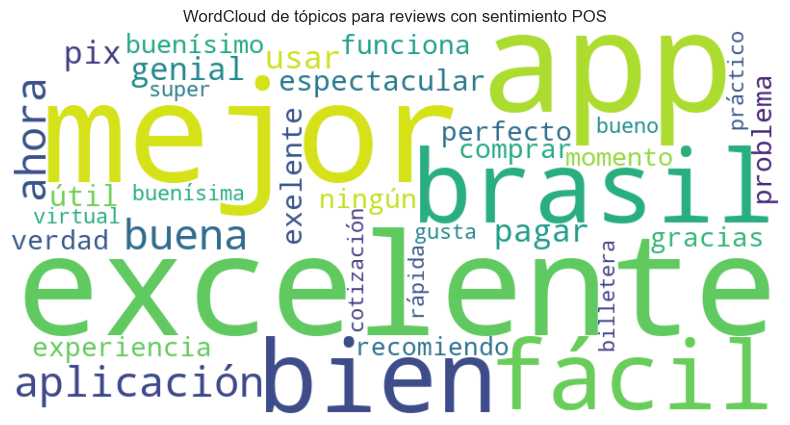

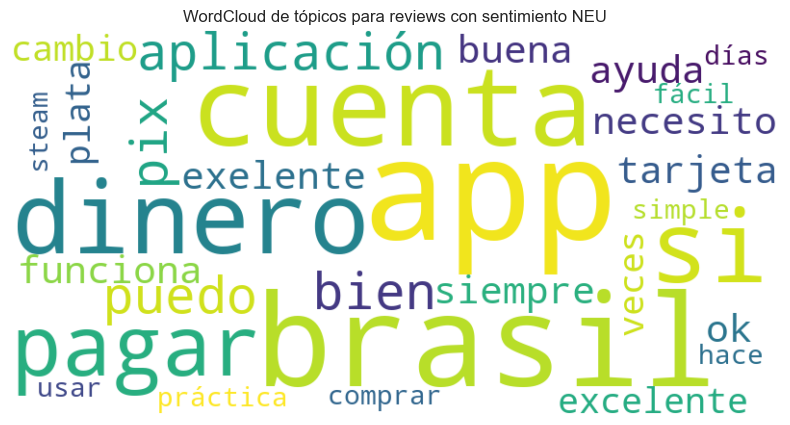

Listado de Feature Requests:


,date,app,store,content,sentiment
0,2025-03-26 01:26:20,belo,Play Store,malisima,NEG
1,2025-03-24 19:40:18,astropay,Play Store,👍,NEU
2,2025-03-24 15:58:59,belo,Play Store,mala,NEG
3,2025-03-24 00:09:13,astropay,Play Store,exelente,NEU
4,2025-03-23 21:45:32,astropay,Play Store,OK,NEU
...,...,...,...,...,...
82,2025-01-13 18:57:11,belo,Play Store,exelente,NEU
83,2025-01-08 14:59:27,belo,Play Store,ok,NEU
84,2025-01-05 17:05:56,belo,Play Store,agil,NEU
85,2025-01-03 08:12:10,belo,Play Store,lo mejor,POS


Listado de Bug Reports:


,date,app,store,content,sentiment
0,2025-03-26 16:38:49,belo,Play Store,no puedo ingresar,NEG
1,2025-03-26 13:25:49,belo,Play Store,no me deja avanzar,NEG
2,2025-03-24 15:58:59,belo,Play Store,mala,NEG
3,2025-03-24 08:18:33,belo,Play Store,no funciona siempre y el cambio es caro,NEG
4,2025-03-20 11:40:03,belo,Play Store,no funciona un dirrección y no anda nada,NEG
5,2025-03-18 19:03:34,belo,Play Store,funciona perfecto,POS
6,2025-03-16 11:15:36,belo,Play Store,No puedo abrir,NEG
7,2025-03-14 17:41:25,belo,Play Store,No abre,NEG
8,2025-03-07 09:31:13,belo,Play Store,Mala,NEG
9,2025-03-03 19:54:10,belo,Play Store,No me gusta,NEG


In [10]:
# Agrupar por app y sentimiento
sentiment_counts_app = all_reviews.groupby(['app', 'sentiment']).size().reset_index(name='Count')

plt.figure(figsize=(10, 6))
sns.barplot(x='sentiment', y='Count', hue='app', data=sentiment_counts_app, palette='viridis')
plt.title("Distribución de Sentimientos por App")
plt.xlabel("Sentimiento")
plt.ylabel("Cantidad de Reviews")
plt.show()

# Agrupar por semana, app y sentimiento
weekly_sentiment_app = all_reviews.groupby(['week', 'app', 'sentiment']).size().reset_index(name='Count')

plt.figure(figsize=(12, 6))
sns.lineplot(x='week', y='Count', hue='sentiment', style='app', data=weekly_sentiment_app, markers=True)
plt.title("Evolución Semanal de los Sentimientos por App")
plt.xlabel("Semana")
plt.ylabel("Cantidad de Reviews")
plt.xticks(rotation=45)
plt.legend(title="Sentimiento / App")
plt.show()

# Mapear el sentimiento a un score numérico
sentiment_map = {"POS": 1, "NEU": 0, "NEG": -1}
all_reviews["sentiment_score"] = all_reviews["sentiment"].map(sentiment_map)

# Visualización: Rating vs Sentiment Score
plt.figure(figsize=(10, 6))
# Boxplot para mostrar la distribución de 'sentiment_score' por rating
sns.boxplot(x="rating", y="sentiment_score", data=all_reviews, hue="app", showfliers=False)
# Stripplot para mostrar cada punto
sns.stripplot(x="rating", y="sentiment_score", data=all_reviews, hue="app", 
              dodge=True, alpha=0.5, color='black', jitter=True)

plt.title("Distribución de Sentiment Score por Rating (posible ironía)")
plt.xlabel("Rating")
plt.ylabel("Sentiment Score")
plt.legend(title="App", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Visualizar los tópicos por sentimiento usando WordCloud
for sentiment in all_reviews['sentiment'].unique():
    subset = all_reviews[all_reviews['sentiment'] == sentiment]['content']
    topics = extract_topics(subset, n_topics=5, n_top_words=10)
    
    # Combinar las palabras clave de todos los tópicos en una única cadena
    all_words = []
    for topic, words in topics.items():
         all_words.extend(words)
    text = " ".join(all_words)
    
    # Generar el WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud de tópicos para reviews con sentimiento {sentiment}")
    plt.show()

# Listado de Feature Requests
features_reviews = all_reviews[all_reviews['is_feature'] == True]
print("Listado de Feature Requests:")
display(features_reviews[['date', 'app', 'store', 'content', 'sentiment']].sort_values(by='date', ascending=False).reset_index(drop=True))

# Listado de Bug Reports para la app 'belo'
bugs_reviews = all_reviews[(all_reviews['is_bug'] == True) & (all_reviews['app'] == 'belo')]
print("Listado de Bug Reports:")
display(bugs_reviews[['date', 'app', 'store', 'content', 'sentiment']].sort_values(by='date', ascending=False).reset_index(drop=True))

In [9]:
# Guardar todas las reviews con análisis de sentimiento
all_reviews.to_csv("all_reviews.csv", index=False)

# Guardar el resumen semanal
weekly_summary.to_csv("weekly_summary.csv", index=False)

# Guardar feature requests
features_reviews.to_csv("features_reviews.csv", index=False)

# Guardar bug reports
bugs_reviews.to_csv("bugs_reviews.csv", index=False)